# 1. Introduction
In this note I want to discuss a (potentially) simplified view of the Expectation Maximization (EM) algorithm. The EM algorithm is used to find local MLE/MAP estimates either when there's missing values in the data or we introduce latent variables to make the complete likelihood of the model easier to compute. For ease of discussion let us restrict to the case of ML estimation to introduce the algorithm.

Suppose we observe data $\mathbf{x}$ and have a corresponding family of parametric models $\{p(\mathbf{\cdot}|\theta)\}_{\theta\in \Theta}$. In frequentist statistics we then proceed to find the ML estimate by maximizing the likelihood, or, equivalently, maximizing the log likelihood. 
$$
\theta_{MLE} = \underset{\theta\in \Theta}{\operatorname{argmax}} \log L(\theta; \mathbf{x}).
$$

It may be the case that this estimate is hard to compute numerically, even in the simpler cases, because of the structure of the likelihood function. (We will see this with a very simple model soon). In this case, we may be able to factorize the likelihood more cleanly if we introduce some latent variable $\mathbf{z}$, i.e., 
$$
\log L(\theta; \mathbf{x}, \mathbf{z}) = \log L(\theta; \mathbf{z}) + \log L(\theta; \mathbf{x}|\mathbf{z})
$$
may be more amenable to optimization. Well, but you'd say that this doesn't help, because we don't know what the latent variables are, and how can we be sure that the MLE from this gives us the correct MLE for the original problem! You are quite right, now that we are getting to the meat of the EM algorithm.

# 2. Setting up the lower bound objective

We are actually not so far from the answer. Observe that we can rewrite the log likelihood in terms of the complete likelihood and the conditional likelihood:

$$
\log L(\theta; \mathbf{x}) = \log L(\theta; \mathbf{x}, \mathbf{z}) - \log L(\theta; \mathbf{z}|\mathbf{x})
$$

But this upsets us because we can't observe the latent variable $\mathbf{z}$, so we can't compute the likelihood upon seeing only $\mathbf{x}$ this way. The usual way out would be to integrate over all possible $\mathbf{z}$. However, another interesting approach is to plug in a variational distribution over $\mathbf{z}$, and we denote its density conditioned on $\mathbf{x}$ by $q(\mathbf{z}|\mathbf{x})$. It will sum to $1$ over all $\mathbf{z}$. Let us assume $\mathbf{z}$ takes discrete values wlog:
$$
\log L(\theta; \mathbf{x}) = \sum_z q(\mathbf{z}|\mathbf{x}) \log \left(\frac{L(\theta; \mathbf{x}, \mathbf{z})}{q(\mathbf{z}|\mathbf{x})}\frac{q(\mathbf{z}|\mathbf{x})}{L(\theta; \mathbf{z}|\mathbf{x})}\right) 
$$

We can then write this as
$$
\log L(\theta; \mathbf{x}) = \sum_z q(\mathbf{z}|\mathbf{x}) \log \left(\frac{L(\theta; \mathbf{x}, \mathbf{z})}{q(\mathbf{z}|\mathbf{x})}\right) + D_{KL}(q(\mathbf{z}|\mathbf{x})\|L(\theta; \mathbf{z}|\mathbf{x})) 
$$

The KL divergence term is nonnegative and is minimized when our variational distribution matches the true conditional likelihood of the latent variables. Hence, we can maximize the middle term in the equation above as a lower bound to $\log L(\theta; \mathbf{x})$, i.e., we define an objective function
$$
F(q, \theta) = \sum_z q(\mathbf{z}|\mathbf{x}) \log \left(\frac{L(\theta; \mathbf{x}, \mathbf{z})}{q(\mathbf{z}|\mathbf{x})}\right) = \log L(\theta; \mathbf{x}) - D_{KL}(q(\mathbf{z}|\mathbf{x})\|L(\theta; \mathbf{z}|\mathbf{x})) 
$$
When this is maximized, the KL divergence term will be zero, and our original log likelihood will be maximized.

Finally, we need to specify the variational family. Well, given what we have, it's natural to use $q_\theta(\mathbf{z}|\mathbf{x}) = L(\theta; \mathbf{z}|\mathbf{x})$. i.e., we parametrize with the conditional probability from our model.

# 3. Optimization routine

In this light, although a bit different from the conventional approach, we see that EM as an algorithm to approximate the max likelihood parameter given some data amounts to maximizing the objective function $F$ over $q$ and $\theta$. EM consists of the E step and the M step. In the E (expectation) step, we maximize $F$ over $q$ only, and the maximum is achieved at taking $q=q_{\tilde{\theta}}$ where $\tilde{\theta}$ is the current estimate of the model parameter, because only then the KL term is minimized to $0$. The meaning of this step is to compute the best guess of the latent variable distribution given our data and the current parameter estimate. Next, in the M step, we maximize $F$ over $\theta$ only, and the meaning of this step is to update our estimate of model parameter based on the guess of the latent distribution. The two steps are alternated to maximize $F$ until convergence, and by our previous discussion, we are guaranteed to improve our target log likelihood from the initial calculation because $F$ is a lower bound. Note, we may well hit a local maximum, so EM algorithms do not guarantee that we can find a good estimate of the global max likelihood. But given the model structure, in practice, EM often performs okay.

# 4. Example application to a two-component Gaussian mixture model

This example is adapted from the Elements of Statistical Learning. It shows the application of EM algorithm in the simplest scenario when the latent variable is discrete and the observed variable is continuous. Let us assume we have observed some data that shows a bimodal empirical distribution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mu_1, mu_2 = -2, 3
sigma_1, sigma_2 = 0.8, 1.2
N = 1000
p = 0.4


np.random.seed(42)
data = np.concatenate((np.random.normal(mu_1, sigma_1, int(N*p)),
                       np.random.normal(mu_2, sigma_2, N-int(N*p))))
np.random.shuffle(data)

(array([ 10., 127., 209.,  53.,  28., 114., 225., 163.,  61.,  10.]),
 array([-4.59301387, -3.46424679, -2.3354797 , -1.20671262, -0.07794554,
         1.05082155,  2.17958863,  3.30835572,  4.4371228 ,  5.56588989,
         6.69465697]),
 <BarContainer object of 10 artists>)

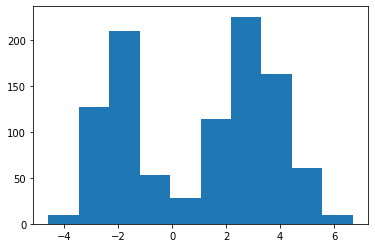

In [2]:
plt.hist(data, bins=10)

We wish to model this dataset by a two-component Gaussian mixture model, i.e., letting the model parameter be $\theta=(\pi, \mu_1,\sigma_1^2, \mu_2, \sigma_2^2)$. We assume each observation from the dataset is drawn independently and can be represented as the random variable $X$ by
$$
X = (1-\Delta) X_1 + \Delta X_2,
$$
where $X_1, X_2$ are two normal distributions with corresponding parameters $\theta_1 = (\mu_1,\sigma_1^2), \theta_2 = (\mu_2,\sigma_2^2)$, and $\Delta$ is a Bernoulli random variable with $P(\Delta = 1)=\pi$.

We let $\phi$ denote the Gaussian pdf, then the log likelihood given data is
$$
\log L(\theta; x) = \sum_{i=1}^N \log[(1-\pi)\phi_{\theta_1}(x_i) + \pi \phi_{\theta_2}(x_i)].
$$

This is difficult to maximize directly in closed-form because of the sum of terms in the logarithm. However, as hinted in the beginning, introducing latent variable could make the complete likelihood factorizable. In this case, we let the latent variable $Z$ be whether each observation can be assigned to the first Gaussian distribution or the second. This is effectively a clustering process. Then the complete log likelihood given data and (supposedly) assignment will be 
$$
\log L(\theta; x, z) =  \log L(\theta; \mathbf{x}|\mathbf{z}) + \log L(\theta; \mathbf{z}) = \sum_{i=1}^N [(1-z_i)\log\phi_{\theta_1}(x_i) + z_i \log\phi_{\theta_2}(x_i)] + \sum_{i=1}^N [(1-z_i)\log(1-\pi)+z_i \log \pi].
$$



# 5. Stochastic EM

This is simiar to the incremental EM variant first proposed by Neal & Hinton (1998). Going back to our definition of $F(q, \theta)$ we see that the sum is combinatorially hard to evaluate, so natural idea would be to evaluate it for each data item in our dataset, similar to the idea for stochastic gradient descent and other algorithms. This applies when $\mathbf{x}=(x_1,\dots, x_n), \mathbf{z}=(z_1,\dots,z_n)$, i.e., we have independent data items. Then $L(\theta; \mathbf{x}, \mathbf{z})=\prod_i L(\theta; x_i, z_i)$. The variational distribution $q_\theta$ will also be factorizable into $q_{\theta,i}$. So we can maximize $F(q, \theta)$ with respect to each $q_{\theta,i}$ in the E step, or perhaps just a subset. In the M step, we need to maximize $\sum_z q(\mathbf{z}|\mathbf{x}) \log L(\theta; \mathbf{x}, \mathbf{z})$ with respect to $\theta$. We can write this alternatively as $\mathbb{E}_{\mathbf{z} \sim q(\mathbf{z}|\mathbf{x})}[\log L(\theta; \mathbf{x}, \mathbf{z})]$ which can be decomposed into $\mathbb{E}_{\mathbf{z} \sim q(\mathbf{z}|\mathbf{x})}[\log L(\theta; \mathbf{x} | \mathbf{z})] + \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z}|\mathbf{x})}[\log L(\theta; \mathbf{z})]$. Applying law of total expectations we can write it as

$$
F(\theta) = \sum_{i=1}^N \mathbb{E}_{z_i\sim q(z_i|x_i)}[\log L(\theta; x_i | z_i)] + \mathbb{E}_{z_i\sim q(z_i|x_i)}[\log L(\theta; z_i)].
$$
Note that this hints at a stochastic variant where we just maximize $F$ over a subset of the data involved in the summation.

In our case, the E step iteratively adjusts the probability that each observation is assigned to one group or another. $$
\gamma_i := q^*_{\theta_t, i}(z_i=1) = P(z_i=1| x_i, \theta_{t-1}) = \frac{P(x_i|z_i=1, \theta_{t-1})P(z_i=1|\theta_{t-1})}{P(x_i|\theta_{t-1})} = \frac{\phi_{\theta_{2, t-1}}(x_i)\pi_{t-1}}{\phi_{\theta_{2, t-1}}(x_i)\pi_{t-1} + \phi_{\theta_{1, t-1}}(x_i)(1-\pi_{t-1})}
$$ 

We will invoked Bayes rule to calculate the probability of latent variable given data. This is a crucial point because we will see later that for variational Bayesian methods, we assume that it's not even feasible to compute this probability in closed form.

Then in the M step, we maximize $\sum_z q(\mathbf{z}|\mathbf{x}) \log L(\theta; \mathbf{x}, \mathbf{z})$, and the log likelihood term can be decomposed in the forward direction specified by our model, into $\log L(\pi; \mathbf{x})+\log L(\theta_1, \theta_2; \mathbf{z}|\mathbf{x})$. We will compute the MLE for each term and then average them by $q(\mathbf{z}|\mathbf{x})$.

For the first term, we have 
$$
\log L(\pi; \mathbf{x}) = \sum_i x_i \log \pi + (1-x_i)\log(1-\pi)
$$
which the form of cross-entropy. It's maximized at $\sum_i x_i / N$. Hence, the weighted estimate will be $\sum \gamma_i / N$ by iterated expectation over each $x_i$. 

Next, we compute MLE for parameters $\theta_1, \theta_2$ that generates data from latent assignments. We will again use the insight from above on using iterated expectations to simplify things. Since
$$
\log L(\theta_1,\theta_2;x_i|z_i) = (1-z_i)\log \phi_{\theta_1}(x_i) + z_i \log \phi_{\theta_2}(x_i)=-(1-z_i)\left[\frac{1}{2} \log \sigma_1^2 - \frac{1}{2}\left(\frac{x_i-\mu_1}{\sigma_1^2}\right)^2\right] - z_i\left[\frac{1}{2}\log \sigma_2^2 - \frac{1}{2}\left(\frac{x_i-\mu_2}{\sigma_2^2}\right)^2\right],
$$
and the expection of this is obtained by substituting $\gamma_i$ for $z_i$, then we sum over all data points and derive the MLEs. For example, for the Normal means as 
$$
\hat{\mu_1} = \frac{\sum_i (1-\gamma_i)x_i}{\sum_i 1-\gamma_i}; \quad \hat{\mu_2} = \frac{\sum_i \gamma_i x_i}{\sum_i \gamma_i}.
$$

The Normal variances are found to be 
$$
\hat{\sigma_1^2} = \frac{\sum_i (1-\gamma_i)(x_i-\mu_1)^2}{\sum_i 1-\gamma_i}; \quad \hat{\sigma_2^2} = \frac{\sum_i \gamma_i (x_i-\mu_2)^2}{\sum_i \gamma_i}.
$$
Note, we'd plug our estimate for $\mu_1,\mu_2$ into the variance MLEs.


It's very nice we obtained closed form formula to update the parameters. This is a result of our judiciously choosing the latent variables and factoring the whole model into two steps.

# 5. Implementation

Finally, we can implement the iterations as described above. We will play with the regular EM and the stochastic variant. A problem we haven't discussed is how to choose the initial guess of the parameters (priors). Let us use $\hat{\pi}=0.5$, $\hat{\mu_1}, \hat{\mu_2}$ as random draws from the data, and $\hat{\sigma_1^2}, \hat{\sigma_2^2}$ would be set to the overall sample variance. These are heuristic choices that should be in the right ballpark of the magnitude for the actual parameters.


In [3]:
from numpy import pi

def norm_density(mu, var, x):
    return (1/((2*pi*var)**(1/2)))*np.exp(-(1/2)*(x-mu)**2/var)

def EM(data, eps=0.001, max_it=20):
    N = len(data)
    p = 0.5
    mu1 = np.random.choice(data, 1)[0]
    mu2 = np.random.choice(data, 1)[0]
    var1 = var2 = np.var(data)
    print(f"Initial guesses {p:.2f}, {mu1:.2f}, {mu2:.2f}, {var1:.2f}, {var2:.2f}")
    
    diff = float('inf')
    it = 0
    while diff > eps and it < max_it:
        # E-step, compute the best variational conditional likelihood for the latent variables
        g = p*norm_density(mu2, var2, data) / ((1-p)*norm_density(mu1, var1, data) + p*norm_density(mu2, var2, data))
        
        # M-step, maximize likelihood over model parameters with the current latent distribution
        p_ = np.sum(g) / N
        mu1_ = np.sum((1-g)*data)/np.sum(1-g)
        mu2_ = np.sum(g*data)/np.sum(g)
        var1_ = np.sum((1-g)*(data-mu1_)**2)/np.sum(1-g)
        var2_ = np.sum(g*(data-mu2_)**2)/np.sum(g)
        all_diff = np.array([p-p_, mu1-mu1_, mu2-mu2_, var1-var1_, var2-var2_])
        rel_diff = np.abs(all_diff / np.array([p_, mu1_, mu2_, var1_, var2_]))
        diff = np.max(rel_diff)
        p, mu1, mu2, var1, var2 = p_, mu1_, mu2_, var1_, var2_
        it += 1
    print(f"Final estimates: {p:.2f}, {mu1:.2f}, {mu2:.2f}, {var1:.2f}, {var2:.2f}, in {it} iterations")
    return p, mu1, mu2, var1, var2, it


def stochastic_EM(full_data, eps=0.001, max_it=20, batch_portion=0.2, lr_schedule='decay'):
    N = len(full_data)
    bs = int(N*batch_portion)
    N_batches = int(np.ceil(1/batch_portion))
    p = 0.5
    mu1 = np.random.choice(full_data, 1)[0]
    mu2 = np.random.choice(full_data, 1)[0]
    var1 = var2 = np.var(full_data)
    print(f"Initial guesses {p:.2f}, {mu1:.2f}, {mu2:.2f}, {var1:.2f}, {var2:.2f}")
    
    diff = float('inf')
    it = 0
    while diff > eps and it < max_it:
        p__, mu1__, mu2__, var1__, var2__ = p, mu1, mu2, var1, var2
        for batch_idx in range(N_batches):
            data=full_data[batch_idx*bs:(batch_idx+1)*bs]
            # E-step, compute the best variational conditional likelihood for the latent variables
            g = p*norm_density(mu2, var2, data) / ((1-p)*norm_density(mu1, var1, data) + p*norm_density(mu2, var2, data))

            # M-step, maximize likelihood over model parameters with the current latent distribution
            p_ = np.sum(g) / bs
            mu1_ = np.sum((1-g)*data)/np.sum(1-g)
            mu2_ = np.sum(g*data)/np.sum(g)
            var1_ = np.sum((1-g)*(data-mu1_)**2)/np.sum(1-g)
            var2_ = np.sum(g*(data-mu2_)**2)/np.sum(g)
            if lr_schedule == 'decay':
                lr = 1/(it+1) # inverse decay rate schedule
            elif lr_schedule == 'none':
                lr = 1
            elif lr_schedule == 'half':
                lr = 0.5
            p = p_*lr+p*(1-lr)
            mu1 = mu1_*lr+mu1*(1-lr)
            mu2 = mu2_*lr+mu2*(1-lr)
            var1 = var1_*lr+var1*(1-lr)
            var2 = var2_*lr+var2*(1-lr)
            
        all_diff = np.array([p-p__, mu1-mu1__, mu2-mu2__, var1-var1__, var2-var2__])
        rel_diff = np.abs(all_diff / np.array([p, mu1, mu2, var1, var2]))
        diff = np.max(rel_diff)
        it += 1
    print(f"Final estimates: {p:.2f}, {mu1:.2f}, {mu2:.2f}, {var1:.2f}, {var2:.2f}, in {it} iterations")
    return p, mu1, mu2, var1, var2, it

Initial guesses 0.50, 3.41, -1.82, 7.09, 7.09
Final estimates: 0.40, 3.00, -2.00, 1.46, 0.56, in 10 iterations
True estimates 0.40, -2.00, 3.00, 0.64, 1.44


(array([0.00885922, 0.11251214, 0.18515777, 0.04695389, 0.02480583,
        0.10099515, 0.19933253, 0.14440534, 0.05404126, 0.00885922]),
 array([-4.59301387, -3.46424679, -2.3354797 , -1.20671262, -0.07794554,
         1.05082155,  2.17958863,  3.30835572,  4.4371228 ,  5.56588989,
         6.69465697]),
 <BarContainer object of 10 artists>)

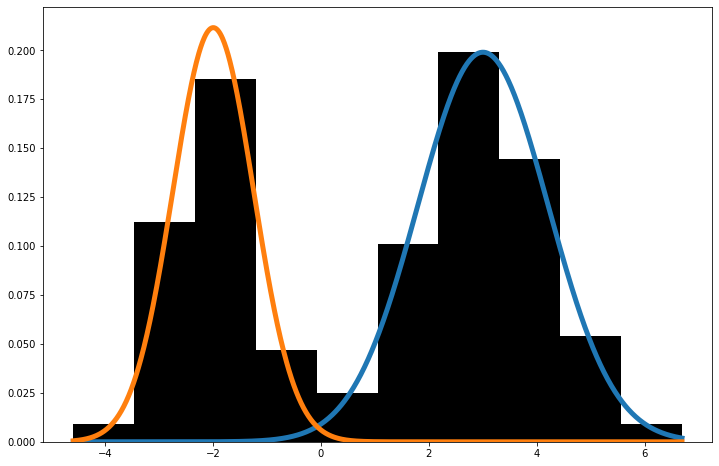

In [9]:
# standard EM
p_hat, mu_1_hat, mu_2_hat, var_1_hat, var_2_hat, _ = EM(data, eps=1e-2, max_it=100)
print(f"True estimates {p:.2f}, {mu_1:.2f}, {mu_2:.2f}, {sigma_1**2:.2f}, {sigma_2**2:.2f}")
fig, ax = plt.subplots(figsize=(12,8))
x = np.linspace(np.min(data), np.max(data), 1000)
p1 = norm_density(mu_1_hat, var_1_hat, x) * (1-p_hat)
p2 = norm_density(mu_2_hat, var_2_hat, x) * p_hat
ax.plot(x, p1, linewidth=5)
ax.plot(x, p2, linewidth=5)
ax.hist(data, density=True, color='k')

Initial guesses 0.50, 3.04, -1.39, 7.09, 7.09
Final estimates: 0.41, 2.95, -2.00, 1.42, 0.55, in 5 iterations
True estimates 0.40, -2.00, 3.00, 0.64, 1.44


(array([0.00885922, 0.11251214, 0.18515777, 0.04695389, 0.02480583,
        0.10099515, 0.19933253, 0.14440534, 0.05404126, 0.00885922]),
 array([-4.59301387, -3.46424679, -2.3354797 , -1.20671262, -0.07794554,
         1.05082155,  2.17958863,  3.30835572,  4.4371228 ,  5.56588989,
         6.69465697]),
 <BarContainer object of 10 artists>)

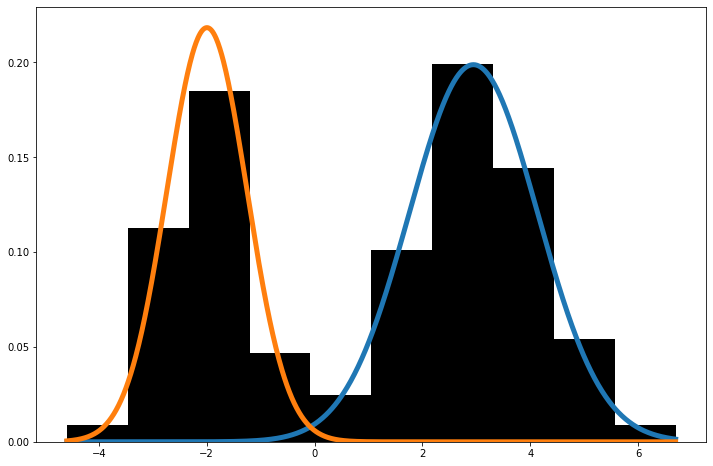

In [7]:
# stochastic EM
p_hat, mu_1_hat, mu_2_hat, var_1_hat, var_2_hat, _ = stochastic_EM(data, eps=1e-2, max_it=100, batch_portion=0.1, lr_schedule='decay')
print(f"True estimates {p:.2f}, {mu_1:.2f}, {mu_2:.2f}, {sigma_1**2:.2f}, {sigma_2**2:.2f}")
fig, ax = plt.subplots(figsize=(12,8))
x = np.linspace(np.min(data), np.max(data), 1000)
p1 = norm_density(mu_1_hat, var_1_hat, x) * (1-p_hat)
p2 = norm_density(mu_2_hat, var_2_hat, x) * p_hat
ax.plot(x, p1, linewidth=5)
ax.plot(x, p2, linewidth=5)
ax.hist(data, density=True, color='k')